In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
#If using script on terminal
#import tqdm
from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = labels[idx]
        return self.transform(new_image), label
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [3]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [4]:
num_pos, num_neg = 400, 600
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'

hdu_list = fits.open(path + 'exp/32.fits')
print(len(hdu_list[1].data))
idx = random.sample(range(len(hdu_list[1].data)), num_pos)
images_pos = hdu_list[1].data[idx,:] 
data_pos = pd.DataFrame(hdu_list[2].data[:][idx])
labels_pos = np.zeros(num_pos, dtype = np.int64)

hdu_list = fits.open(path + 'negative_cases.fits')
print(len(hdu_list[1].data))
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
images_neg = hdu_list[1].data[idx,:] 
labels_neg = np.ones(num_neg, dtype = np.int64)
#Data for negatives, all null
num_columns = len(data_pos.columns)
data_neg = np.full((num_neg, num_columns-1), 0)
data_neg = pd.DataFrame(data_neg, columns=['zl/z1', 'm', 'iso', 'E', 'Magni 1'])
last_column = ['NEG']*num_neg
data_neg['ID'] = last_column

images = np.concatenate((images_pos, images_neg)).astype(np.float32)
data = pd.concat([data_pos, data_neg], axis=0).reset_index(drop=True)
labels = np.concatenate((labels_pos,labels_neg), dtype = np.int64)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = ImageDataset(images, data, labels, transform=transform)

400
19000


In [5]:
train_dataset, test_dataset = make_train_test_datasets(images, data, labels, test_size=0.2, transform=transform)

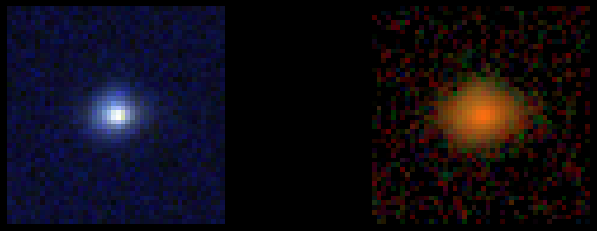

        zl/z1          m       iso         E   Magni 1               ID
339  0.801759  22.481726  0.382703  0.774332  3.607235  POS_320668898_0


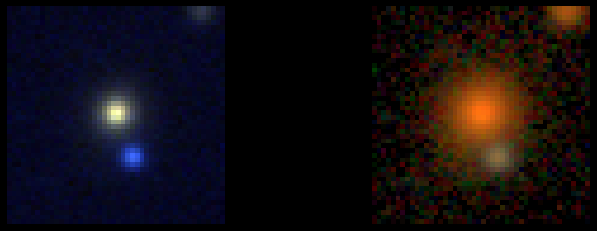

     zl/z1    m  iso    E  Magni 1   ID
916    0.0  0.0  0.0  0.0      0.0  NEG


In [6]:
images, data, labels = train_dataset.images, train_dataset.data, train_dataset.labels
for i in range(2):
    train_dataset.plot_image(i)
    row = data.iloc[[i]]
    print(row)

In [7]:
print(len(train_dataset), len(test_dataset))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, num_workers=0, shuffle=True)
print(len(train_loader), len(test_loader))

800 200
40 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([20, 3, 224, 224])
Labels batch shape: torch.Size([20])
torch.Size([3, 224, 224])


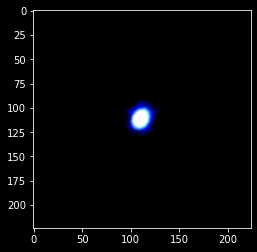

Label: 1


In [8]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[6].squeeze()
print(img.shape)
label = train_labels[6]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
for i_batch, (sample_image, sample_label) in tqdm(enumerate(train_loader)):
    print(sample_label[0])
    if(i_batch == 2): break

0it [00:00, ?it/s]

tensor(1)
tensor(1)
tensor(0)


In [10]:
model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [11]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i_batch, (sample_image, sample_label) in tqdm(enumerate(train_loader)):
        for i, (data, target) in tqdm(enumerate(train_loader)):


            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)


            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [12]:
model = ViTBase16(n_classes=2, pretrained=True)

# Start training processes
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = xm.xla_device()
model.to(device)

# lr = LR * xm.xrt_world_size()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cpu


In [13]:
def fit_tpu(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, 'name_model')
                best_val_acc = valid_acc

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [14]:
logs = fit_tpu(
            model=model,
            epochs=10,
            device=device,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            valid_loader=test_loader,
        )

EPOCH 1 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.53797447681427, ACCURACY: 0.7437500953674316

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.3203829228878021, ACCURACY: 0.8700000047683716

EPOCH 2 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 0.31634023785591125, ACCURACY: 0.8700000643730164

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.13981831073760986, ACCURACY: 0.9549999237060547

EPOCH 3 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 3 - LOSS: 0.2186889350414276, ACCURACY: 0.9150000810623169

start valid_loader
EPOCH 3 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.17126920819282532, ACCURACY: 0.9449999928474426

EPOCH 4 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 4 - LOSS: 0.12758122384548187, ACCURACY: 0.955000102519989

start valid_loader
EPOCH 4 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.11044792830944061, ACCURACY: 0.9599999189376831

EPOCH 5 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 5 - LOSS: 0.1871086061000824, ACCURACY: 0.9400002360343933

start valid_loader
EPOCH 5 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.05360303446650505, ACCURACY: 0.9799998998641968

EPOCH 6 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 6 - LOSS: 0.07404609769582748, ACCURACY: 0.9750002026557922

start valid_loader
EPOCH 6 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.01925651542842388, ACCURACY: 0.9899999499320984

EPOCH 7 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 7 - LOSS: 0.06425538659095764, ACCURACY: 0.9800001382827759

start valid_loader
EPOCH 7 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.024998703971505165, ACCURACY: 0.9950000047683716

EPOCH 8 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 8 - LOSS: 0.06737850606441498, ACCURACY: 0.9700002670288086

start valid_loader
EPOCH 8 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.029271656647324562, ACCURACY: 0.9899999499320984

EPOCH 9 - TRAINING...


0it [00:00, ?it/s]


	[TRAIN] EPOCH 9 - LOSS: 0.06724857538938522, ACCURACY: 0.9774999618530273

start valid_loader
EPOCH 9 - VALIDATING...


  0%|          | 0/10 [00:00<?, ?it/s]

	[VALID] LOSS: 0.015694284811615944, ACCURACY: 0.9950000047683716

EPOCH 10 - TRAINING...


0it [00:00, ?it/s]

KeyboardInterrupt: 